In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
from os import listdir
from os.path import isfile, join
import io
import time

import glob

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Check if any duplicates are in the dataset 

In [3]:
# load data function
IMG_DIM = (150, 150)

dataset_path = os.getcwd()

def apply_permutation(data, indexes):
    n = len(data)
    result = np.empty(n, dtype=object)
    for i in range(n):
        result[i] = data[indexes[i]]
    return result

def load_dataset(data_type):
    path = join(dataset_path, data_type)
    files = []
    labels = []
    f_dir = [f for f in listdir(path) if not isfile(join(path, f))]

    for directory in f_dir:
        new_files = [join(path, directory, f) for f in listdir(join(path, directory)) if isfile(join(path, directory, f))]
        files.extend(new_files)
        for f in new_files:
            labels.append(directory)

    # shuffling data
    shuffled_indices = np.random.permutation(len(files))
    files = apply_permutation(files, shuffled_indices)
    labels = apply_permutation(labels, shuffled_indices)
    imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in files]
    imgs = np.array(imgs)

    return imgs, labels


In [4]:
imgs, labels = load_dataset('train')

train_imgs = imgs
train_labels = labels

imgs, labels = load_dataset('valid')
validation_imgs = imgs
validation_labels = labels

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)


Train dataset shape: (23657, 150, 150, 3) 	Validation dataset shape: (875, 150, 150, 3)


(150, 150, 3)


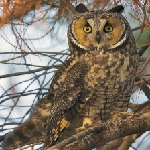

In [5]:
max_instances = 3000
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [6]:
batch_size = 30
num_classes = 175
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['CURL CRESTED ARACURI' 'PURPLE FINCH' 'NICOBAR PIGEON' 'OSPREY'
 'BLUE HERON' 'HOUSE FINCH' 'GRAY PARTRIDGE' 'SORA' 'DOWNY WOODPECKER'
 'FLAME TANAGER'] [ 57 128 109 118  30  90  82 153  60  71]


In [12]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])     
 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002846CB4A278>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002846CB4A748>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002846CCE0828>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002846CB7DB70>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002846CB7D978>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002846CB8A8D0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002846CCB5908>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002846CCB54A8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002846CCC6860>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x0000028479B279B0>,block3_conv3,False


In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(175, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [18]:
from keras import callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_bird_classifier_model.h5", save_best_only=True) 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[checkpoint_cb],
                    verbose=1) 

Train on 23657 samples, validate on 875 samples
Epoch 1/30
23657/23657 [==============================] - 8649s 366ms/step - loss: 5.0968 - accuracy: 0.0183 - val_loss: 4.9152 - val_accuracy: 0.0229
Epoch 2/30
23657/23657 [==============================] - 8637s 365ms/step - loss: 4.5036 - accuracy: 0.0705 - val_loss: 3.7764 - val_accuracy: 0.1554
Epoch 3/30
23657/23657 [==============================] - 8526s 360ms/step - loss: 3.2741 - accuracy: 0.2365 - val_loss: 2.4647 - val_accuracy: 0.3863
Epoch 4/30
23657/23657 [==============================] - 8639s 365ms/step - loss: 2.2626 - accuracy: 0.4381 - val_loss: 1.5890 - val_accuracy: 0.5863
Epoch 5/30
23657/23657 [==============================] - 8646s 365ms/step - loss: 1.6009 - accuracy: 0.5882 - val_loss: 1.1413 - val_accuracy: 0.6926
Epoch 6/30
23657/23657 [==============================] - 8204s 347ms/step - loss: 1.2072 - accuracy: 0.6890 - val_loss: 0.8490 - val_accuracy: 0.7691
Epoch 7/30
23657/23657 [======================

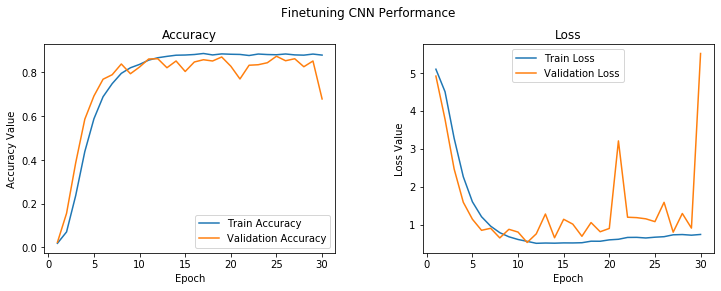

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Finetuning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")